<img src="kindergarten.png" width="40%" height="40%"></img>

<h1 align="center">Pre-primary Education in Belarus</h1>

## Table of Contents



1. [Introduction](#0)<br>
2. [Business understanding](#1) <br>
3. [Data requirements](#2)<br>
4. [Methodology](#3)<br>
5. [Results](#4)<br>
6. [Discussion](#5)<br>
7. [Conclusion](#6)<br>

<hr>

## Introduction <a id="0"></a>

Much of the success of future life depends on the acquiring of education. How much an adult’s life will be significant and smooth depends to a large extent on their childhood education. Since children are the future, it is important to give special importance to child’s education system.

But there has been disapointing trends in Belarus last years: count of kindergartens decreases while count of children in kindergartens increases. 

In [1]:
from matplotlib import pyplot as plt
years = [y+1 for y in range(2012, 2018)]
kindergartens = [4081, 4064, 4027, 3972, 3951, 3879]
children = [387.4, 398, 407, 410.6, 409.8, 418.1]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(8, 4))

fig.suptitle('Pre-primary education in Belarus', fontsize=18)

ax1.plot(years, kindergartens, color='blue')
ax1.set_title('Kindergartens', fontsize=14)
ax1.set_xlabel('year')
ax1.set_ylabel('unit')
ax1.set(frame_on=False)

ax2.plot(years, children, color='orange')
ax2.set_title('Children in kindergartens', fontsize=14)
ax2.set_xlabel('year')
ax2.set_ylabel('thousand')
ax2.set(frame_on=False)

fig.tight_layout()

plt.subplots_adjust(top=0.8)
plt.show()

<Figure size 800x400 with 2 Axes>

## Business understanding <a id="1"></a>

A private investor makes a decision to support the UNESCO programme and build 5 kindergartens in Belarus.

The purpose of this project to help this ivestor to select 5 cities in Belarus, the most needy in such initiative. 
This project aims to provide a solution using the methodology of data science and clustering method. 

<b>Target audience</b>

This project is especially useful for children and parents in Belarus because can improve the level of pre-primary education. 
New kindergartens are also new workplaces for nursery teachers.
The governement is intrested of this project too.

## Data requirements <a id="2"></a>

To solve the problem we need the following data:
* list the biggest cities in Belarus
* latitude and longitude of cities
* population data
* childbirth data
* count of kindergartens from the perspective of every city

<b>Data sources:</b>
* https://www.belstat.gov.by/ - the website of the National Statistical Committee in Belarus
* https://www.worldometers.info/ - world statistics are published by a small and independent digital media company based in the United States.

<b>Data extraction tools and methods:</b>
* Beautiful Soup - for pulling data out of HTML
* Pandas library - for download data from .xlsx and processing data
* Geocoder library - for get latitude and longitude of cities
* Foursquare API - for receiving data on institutions of various types in cities

## Methodology <a id="3"></a>

<ol>
   <li>
To understand why we observe decreasing number of kindergartens in parallel to increasing number of children in kindergartens, get data about urban population and fertility rate in Belarus during last years.
       <ul>
           <li>Web-scraping data from <a href="https://www.worldometers.info/world-population/belarus-population/" target="_blank">worldometers.info</a> (BeautifulSoup)</li>
           <li>Data Visualization using Matplotlib</li>
           <br>
       </ul>
    </li>
    <li>
        Looking at the demographic trends, we can assime that kidergartens are closing in small cities because people move to big cities for seek employment. Thus we create dataframe from:
        <ul>
            <li>the 50 biggest cities in Belarus - web-scraping from <a href="https://www.worldometers.info/world-population/belarus-population/" target="_blank">worldometers.info</a> (BeatifulSoup)</li>
            <li>latitude and longitude for each city from <a href="https://www.geonames.org/" target="_blank">GeoNames</a> using geocoder</li>
            <li>number of preschools in each city using Foursquare API</li>
            <li>mean number of newborns and kindergartens  within last 5 years for each city - upload .xlsx from <a href="https://www.belstat.gov.by/" target="_blank">National Statistical Committee in Belarus</a></li>
            <li>funded ratio is the result of division number of kindergartents to numbers of newborns</li>
            <br>
        </ul>
    </li>
    <li>To select the most suitable cities for build 5 new kindergartens, we  cluster them using k-means
    </li>

</ol>


In [2]:
#import libraries
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests
import geocoder
import folium # map rendering library

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [3]:
#web-scraping from worldometers.info
webpage = requests.get("https://www.worldometers.info/world-population/belarus-population/")
soup = BeautifulSoup(webpage.content, "html.parser")
# saving to DataFrame tables
table = soup.find_all('table')

In [4]:
# get data from table with urban population and fertility rate
df_trend = pd.read_html(str(table))[-3]
df_trend.head(5)

,Year,Population,Yearly % Change,Yearly Change,Migrants (net),Median Age,Fertility Rate,Density (P/Km²),Urban Pop %,Urban Population,Country's Share of World Pop,World Population,BelarusGlobal Rank
0,2020,9449323,-0.03 %,-3088,8730,40.3,1.71,47,79.2 %,7483636,0.12 %,7794798739,96
1,2019,9452411,0.00 %,-206,8730,39.7,1.66,47,78.9 %,7456954,0.12 %,7713468100,95
2,2018,9452617,0.03 %,2386,8730,39.7,1.66,47,78.6 %,7428871,0.12 %,7631091040,95
3,2017,9450231,0.05 %,4588,8730,39.7,1.66,47,78.3 %,7397955,0.13 %,7547858925,94
4,2016,9445643,0.07 %,6220,8730,39.7,1.66,47,77.9 %,7362328,0.13 %,7464022049,93


In [5]:
# pre-processing data about urban population and fertility rate
df_trend.dropna(inplace = True) #remove rows with NaN values
df_trend.reset_index(drop=True, inplace=True) #update counting index

years = df_trend['Year'].head(9).values # only fresh years (from 2000)
years = list(reversed(years)) # reorder from old to new

fertility = df_trend['Fertility Rate'].head(9).values
fertility = list(reversed(fertility))

urban = df_trend['Urban Population'].head(9).values
urban = list(reversed(urban))
urban = [round(item/1000000,2) for item in urban] # to simplify, transform 7 523 567 to 7.52 

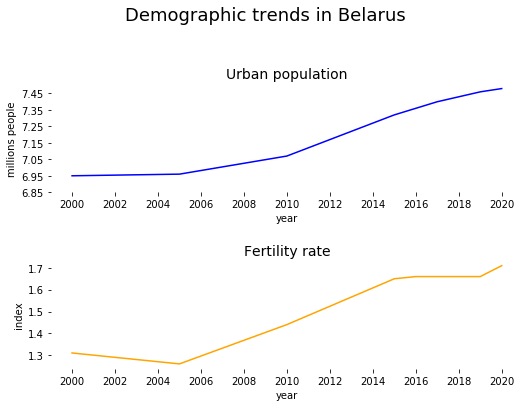

In [6]:
# Data Visualization about urban population and fertility rate
locator = matplotlib.ticker.MultipleLocator(2)
formatter = matplotlib.ticker.StrMethodFormatter("{x:.0f}")


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(8, 6))

fig.suptitle('Demographic trends in Belarus', fontsize=18)

ax1.plot(years, urban, color='blue')
ax1.set_title('Urban population', fontsize=14)
ax1.set_xlabel('year')
ax1.set_ylabel('millions people')
ax1.set(frame_on=False)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
ax1.set_yticks(np.arange(min(urban)-0.1,max(urban),0.1))

ax2.plot(years, fertility, color='orange')
ax2.set_title('Fertility rate', fontsize=14)
ax2.set_xlabel('year')
ax2.set_ylabel('index')
ax2.set(frame_on=False)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)

fig.tight_layout(pad =3)

plt.subplots_adjust(top=0.8)
plt.show()

In [7]:
# get data from table with city title and total population
df = pd.read_html(str(table))[-1]
df.head(5)

,#,CITY NAME,POPULATION
0,1,Minsk,1742124
1,2,Homyel',480951
2,3,Mahilyow,369200
3,4,Vitebsk,342700
4,5,Hrodna,317365


In [8]:
#pre-processing data about the biggest cities in Belarus
df.drop('#', axis=1, inplace=True) # drop column 
df.columns = map(str.lower, df.columns) # transform 'POPULATION' -> 'population'
df.rename(columns={'city name':'city'}, inplace=True) # rename column
df.head()

,city,population
0,Minsk,1742124
1,Homyel',480951
2,Mahilyow,369200
3,Vitebsk,342700
4,Hrodna,317365


In [9]:
#add latitude, longitude, region from each city using geocoder
for index, row in df.iterrows():
    g = geocoder.geonames(row['city'], country=['BY'], key='mildred')
    df.loc[index,'lat'] = g.lat
    df.loc[index,'lng'] = g.lng
    df.loc[index,'region'] = g.state
df.head()

,city,population,lat,lng,region
0,Minsk,1742124,53.9,27.56667,Minsk City
1,Homyel',480951,52.4345,30.9754,Homyel’ Voblasc’
2,Mahilyow,369200,53.9168,30.3449,Mogilev
3,Vitebsk,342700,55.1904,30.2049,Vitebsk
4,Hrodna,317365,53.6884,23.8258,Grodnenskaya


In [10]:
#add preschools using Foursquare API
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius
CLIENT_ID = 'V525NYINSNTY55CWHRJQVZEVFFXIWQTLLXAJJR3P45JX4KXM' # my Foursquare ID
CLIENT_SECRET = 'CUJDXV0XIURO5AIQTKIRRHR3XF3BHHZ5NJMAEFD0Q0UDVBMW' # my Foursquare Secret
VERSION = '20200427' # Foursquare API version

for index, row in df.iterrows():
    # create the API request URL
    latitude = row['lat']
    longitude = row ['lng']
    url = 'https://api.foursquare.com/v2/venues/search?categoryId=52e81612bcbc57f1066b7a45&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
    # make the GET request
    results = requests.get(url).json()["response"]["venues"]
    df.loc[index,'preschools'] = len(results)

df.head()

,city,population,lat,lng,region,preschools
0,Minsk,1742124,53.9,27.56667,Minsk City,33.0
1,Homyel',480951,52.4345,30.9754,Homyel’ Voblasc’,1.0
2,Mahilyow,369200,53.9168,30.3449,Mogilev,3.0
3,Vitebsk,342700,55.1904,30.2049,Vitebsk,0.0
4,Hrodna,317365,53.6884,23.8258,Grodnenskaya,0.0


In [11]:
#add data about nuewborns and kindergartens accoding National Statistical Committee in Belarus
df_stat = pd.read_excel('BY kindergartens.xlsx')
df = pd.merge(df,df_stat, on ='city')
df.head()

,city,population,lat,lng,region,preschools,newborns,kindergartens
0,Minsk,1742124,53.9,27.56667,Minsk City,33.0,17601.0,465.0
1,Homyel',480951,52.4345,30.9754,Homyel’ Voblasc’,1.0,4688.0,127.0
2,Mahilyow,369200,53.9168,30.3449,Mogilev,3.0,3545.0,100.0
3,Vitebsk,342700,55.1904,30.2049,Vitebsk,0.0,3228.0,96.0
4,Hrodna,317365,53.6884,23.8258,Grodnenskaya,0.0,3976.0,92.0


In [12]:
#pre-processing data (final touches)
df.dropna(inplace = True) #remove rows with NaN values
df.reset_index(drop=True, inplace=True) #update counting index
df['funded ratio']=df['kindergartens']/df['newborns'] #add new column
df.tail()

,city,population,lat,lng,region,preschools,newborns,kindergartens,funded ratio
42,Bykhaw,17500,53.521,30.2454,Mogilev,0.0,204.0,6.0,0.029412
43,Lyepyel',17400,54.8814,28.699,Vitebsk,0.0,163.0,8.0,0.049080
44,Mosty,16102,53.4122,24.5387,Grodnenskaya,0.0,178.0,5.0,0.028090
45,Shchuchyn,15700,53.6014,24.7465,Grodnenskaya,0.0,156.0,6.0,0.038462
46,Stowbtsy,15500,53.4785,26.7434,Minsk,0.0,214.0,8.0,0.037383


In [13]:
#Clustering with k-means
X = df[['population', 'newborns', 'kindergartens','funded ratio','preschools']]
X = X.values
X = StandardScaler().fit_transform(X)

kclusters = 6
k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

df['cluster'] = labels
df.head()

,city,population,lat,lng,region,preschools,newborns,kindergartens,funded ratio,cluster
0,Minsk,1742124,53.9,27.56667,Minsk City,33.0,17601.0,465.0,0.026419,1
1,Homyel',480951,52.4345,30.9754,Homyel’ Voblasc’,1.0,4688.0,127.0,0.027090,3
2,Mahilyow,369200,53.9168,30.3449,Mogilev,3.0,3545.0,100.0,0.028209,3
3,Vitebsk,342700,55.1904,30.2049,Vitebsk,0.0,3228.0,96.0,0.029740,3
4,Hrodna,317365,53.6884,23.8258,Grodnenskaya,0.0,3976.0,92.0,0.023139,3


In [14]:
# Look at cluster's key indicators 
df[['city', 'population', 'newborns', 'kindergartens', 'funded ratio','cluster']].groupby(['cluster'])\
                                                                                .agg(['count', 'min', 'mean','max'])

population                                 newborns           \
             count      min          mean      max    count      min   
cluster                                                                
0                9    15500  2.613144e+04    47300        9    156.0   
1                1  1742124  1.742124e+06  1742124        1  17601.0   
2               13    16102  8.873792e+04   220517       13    178.0   
3                5   300715  3.621862e+05   480951        5   3228.0   
4                7    17400  4.194400e+04   100885        7    163.0   
5               12    24200  6.145633e+04   130777       12    244.0   

                               kindergartens                            \
                 mean      max         count    min        mean    max   
cluster                                                                  
0          254.000000    444.0             9    6.0    9.777778   17.0   
1        17601.000000  17601.0             1  465.0  465.000000  465.0   
2          862.307692   2019.0            13    5.0   25.076923   61.0   
3         3867.200000   4688.0             5   77.0   98.400000  127.0   
4          381.571429    791.0             7    8.0   18.142857   34.0   
5          674.500000   1483.0            12    6.0   14.583333   33.0   

        funded ratio                                
               count       min      mean       max  
cluster                                             
0                  9  0.036082  0.038524  0.042328  
1                  1  0.026419  0.026419  0.026419  
2                 13  0.025196  0.028920  0.033571  
3                  5  0.019749  0.025585  0.029740  
4                  7  0.042984  0.048063  0.052838  
5                 12  0.016667  0.022253  0.025424

In [15]:
# Results on the geographic map
capital = df[df.city == "Minsk"]
latitude = float(capital.lat)
longitude = float(capital.lng)
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['lat'], df['lng'], df['city'], df['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results <a id="4"></a>
<img src="clusters.png" width="40%" height="40%"></img>
<br>
If look at above, we can notice 6 clusters:

1. cluster 0(red): small cities with middle finded ratio
2. cluster 1(purple): megapolis with low finded ratio
3. cluster 2(blue): upper-middle cities with low finded ratio
4. cluster 3(aquamarin): high cities wit low finded ratio
5. cluster 4(green): small cities with high finded ratio
6. cluster 5(orange): middle cities with low finded ratio


## Discussion <a id="5"></a>

Based on the world demographic trends, the investor should decide in favour the cities with high level of population and low number of kindergartens.

This is the cluster3(aquamarin) - the region centers of Belarus

In [26]:
df[df.cluster==3].city

1     Homyel'
2    Mahilyow
3     Vitebsk
4      Hrodna
5       Brest
Name: city, dtype: object

#### Limitations

* little statistical data on the open access
* free version Geonames, Foursquare API limits call numbers and detalisation level

#### Suggestions

* I would like also to draw attention to the low popularity of Foursquare in Belarus that may affect the reliability of research results. So I would like to propose to develop this product for Eastern Europe.

## Conclusion <a id="6"></a>

In this project we went through all stages of Data Science methodology from   business understanding to results presentation. 

This specialization from IBM is the fascinating journey, isn't it?
Thank you for your attention, my classmate! 